In [18]:
import pandas as pd
from pandas.io.json import json_normalize
import dask.dataframe as dd
import pyarrow as pa
import json

pd.set_option('display.max_columns', 500)

In [4]:
def lateral_flatten(df):
    rows = []
    for i, row in df.iterrows():
        particpiant_identities = row.at['participantIdentities']
        lateral_pi = json_normalize(particpiant_identities)
        participants = row.at['participants']
        lateral_p = json_normalize(participants, meta_prefix='participant')
        teams = row.at['teams']
        lateral_teams = json_normalize(teams, meta_prefix ='team')
        
        merge1 = pd.merge(lateral_pi, lateral_p, on='participantId')
        merge2 = pd.merge(merge1, lateral_teams, on='teamId')
        
        for j, participant_row in merge2.iterrows():
            new = row.copy()
            
            new_row = pd.concat([new, participant_row])
            rows.append(new_row)

    df2 = pd.DataFrame(rows)
    return df2.drop(['participantIdentities', 'participants', 'teams'], axis=1)

In [5]:
def flattencolumns(df1, cols):
    df = pd.concat([pd.DataFrame(df1[x].values.tolist()).add_prefix(x) for x in cols], axis=1)
    return pd.concat([df, df1.drop(cols, axis=1)], axis=1)

In [6]:
ddf = dd.read_json(
    './s3_sync/2018/*/*/*/*',
    lines=True,
    convert_axes=True
)

In [7]:
ddf.npartitions

961

In [8]:
df = ddf.compute()

In [9]:
df.shape

(3091, 13)

In [10]:
df.head()

,gameCreation,gameDuration,gameId,gameMode,gameType,gameVersion,mapId,participantIdentities,participants,platformId,queueId,seasonId,teams
0,1514771042009,866,2684129583,SNOWURF,MATCHED_GAME,7.24.212.5337,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,1010,9,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ..."
1,1514768844047,1443,2684113425,SNOWURF,MATCHED_GAME,7.24.212.5337,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,1010,9,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T..."
0,1514774717468,1346,2684168850,SNOWURF,MATCHED_GAME,7.24.212.5337,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,1010,9,"[{'teamId': 100, 'win': 'Win', 'firstBlood': T..."
1,1514772360903,1265,2684143700,SNOWURF,MATCHED_GAME,7.24.212.5337,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,1010,9,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ..."
0,1514776794525,1038,2684186671,SNOWURF,MATCHED_GAME,7.24.212.5337,11,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",NA1,1010,9,"[{'teamId': 100, 'win': 'Fail', 'firstBlood': ..."


In [11]:
df.gameCreation = pd.to_datetime(df['gameCreation'], origin='unix', unit='ms')

In [13]:
df2 = lateral_flatten(df).reset_index(drop=True)

In [14]:
df2.head()

,gameCreation,gameDuration,gameId,gameMode,gameType,gameVersion,mapId,platformId,queueId,seasonId,participantId,player.accountId,player.currentAccountId,player.currentPlatformId,player.matchHistoryUri,player.platformId,player.profileIcon,player.summonerId,player.summonerName,championId,highestAchievedSeasonTier,spell1Id,spell2Id,stats.assists,stats.champLevel,stats.combatPlayerScore,stats.damageDealtToObjectives,stats.damageDealtToTurrets,stats.damageSelfMitigated,stats.deaths,stats.doubleKills,stats.firstBloodAssist,stats.firstBloodKill,stats.firstInhibitorAssist,stats.firstInhibitorKill,stats.firstTowerAssist,stats.firstTowerKill,stats.goldEarned,stats.goldSpent,stats.inhibitorKills,stats.item0,stats.item1,stats.item2,stats.item3,stats.item4,stats.item5,stats.item6,stats.killingSprees,stats.kills,stats.largestCriticalStrike,stats.largestKillingSpree,stats.largestMultiKill,stats.longestTimeSpentLiving,stats.magicDamageDealt,stats.magicDamageDealtToChampions,stats.magicalDamageTaken,stats.neutralMinionsKilled,stats.neutralMinionsKilledEnemyJungle,stats.neutralMinionsKilledTeamJungle,stats.objectivePlayerScore,stats.participantId,stats.pentaKills,stats.perk0,stats.perk0Var1,stats.perk0Var2,stats.perk0Var3,stats.perk1,stats.perk1Var1,stats.perk1Var2,stats.perk1Var3,stats.perk2,stats.perk2Var1,stats.perk2Var2,stats.perk2Var3,stats.perk3,stats.perk3Var1,stats.perk3Var2,stats.perk3Var3,stats.perk4,stats.perk4Var1,stats.perk4Var2,stats.perk4Var3,stats.perk5,stats.perk5Var1,stats.perk5Var2,stats.perk5Var3,stats.perkPrimaryStyle,stats.perkSubStyle,stats.physicalDamageDealt,stats.physicalDamageDealtToChampions,stats.physicalDamageTaken,stats.playerScore0,stats.playerScore1,stats.playerScore2,stats.playerScore3,stats.playerScore4,stats.playerScore5,stats.playerScore6,stats.playerScore7,stats.playerScore8,stats.playerScore9,stats.quadraKills,stats.sightWardsBoughtInGame,stats.timeCCingOthers,stats.totalDamageDealt,stats.totalDamageDealtToChampions,stats.totalDamageTaken,stats.totalHeal,stats.totalMinionsKilled,stats.totalPlayerScore,stats.totalScoreRank,stats.totalTimeCrowdControlDealt,stats.totalUnitsHealed,stats.tripleKills,stats.trueDamageDealt,stats.trueDamageDealtToChampions,stats.trueDamageTaken,stats.turretKills,stats.unrealKills,stats.visionScore,stats.visionWardsBoughtInGame,stats.wardsKilled,stats.wardsPlaced,stats.win,teamId,timeline.creepsPerMinDeltas.0-10,timeline.csDiffPerMinDeltas.0-10,timeline.damageTakenDiffPerMinDeltas.0-10,timeline.damageTakenPerMinDeltas.0-10,timeline.goldPerMinDeltas.0-10,timeline.lane,timeline.participantId,timeline.role,timeline.xpDiffPerMinDeltas.0-10,timeline.xpPerMinDeltas.0-10,bans,baronKills,dominionVictoryScore,dragonKills,firstBaron,firstBlood,firstDragon,firstInhibitor,firstRiftHerald,firstTower,inhibitorKills,riftHeraldKills,towerKills,vilemawKills,win,timeline.creepsPerMinDeltas.10-20,timeline.csDiffPerMinDeltas.10-20,timeline.damageTakenDiffPerMinDeltas.10-20,timeline.damageTakenPerMinDeltas.10-20,timeline.goldPerMinDeltas.10-20,timeline.xpDiffPerMinDeltas.10-20,timeline.xpPerMinDeltas.10-20,timeline.creepsPerMinDeltas.20-30,timeline.creepsPerMinDeltas.30-end,timeline.csDiffPerMinDeltas.20-30,timeline.csDiffPerMinDeltas.30-end,timeline.damageTakenDiffPerMinDeltas.20-30,timeline.damageTakenDiffPerMinDeltas.30-end,timeline.damageTakenPerMinDeltas.20-30,timeline.damageTakenPerMinDeltas.30-end,timeline.goldPerMinDeltas.20-30,timeline.goldPerMinDeltas.30-end,timeline.xpDiffPerMinDeltas.20-30,timeline.xpDiffPerMinDeltas.30-end,timeline.xpPerMinDeltas.20-30,timeline.xpPerMinDeltas.30-end,masteries,runes
0,2018-01-01 01:44:02.009,866,2684129583,SNOWURF,MATCHED_GAME,7.24.212.5337,11,NA1,1010,9,1,35897455,35897455,NA1,/v1/stats/player_history/NA/35897455,NA,3168,22208345.0,Xcuter,76,SILVER,4,39,2,11,0,3586,1920,3934,8,0,False,False,False,False,False,False,8364,6535,0,3285,2424,3020,1058,1026,1052,3340,1,4,279,2,1,190,52768,8360,7316,4,0.0,0.0,0,1,0,8229.0,883.0,0.0,0.0,8224.0,427.0,0.0,0.0,8234.0,

In [44]:
df3 = df2.drop(['bans', 'runes', 'masteries'], axis=1)

In [48]:
df3 = df3.astype({
    'stats.firstBloodKill': 'bool'
})

In [49]:
df3.to_parquet('./lateral.snappy.parquet', engine='pyarrow', compression='snappy')

In [ ]:
# 61079726

In [14]:
df2.shape

(29802, 173)

In [15]:
df2.head()

,gameCreation,gameDuration,gameId,gameMode,gameType,gameVersion,mapId,platformId,queueId,seasonId,participantId,player.accountId,player.currentAccountId,player.currentPlatformId,player.matchHistoryUri,player.platformId,player.profileIcon,player.summonerId,player.summonerName,championId,highestAchievedSeasonTier,spell1Id,spell2Id,stats.assists,stats.champLevel,stats.combatPlayerScore,stats.damageDealtToObjectives,stats.damageDealtToTurrets,stats.damageSelfMitigated,stats.deaths,stats.doubleKills,stats.firstBloodAssist,stats.firstBloodKill,stats.firstInhibitorAssist,stats.firstInhibitorKill,stats.firstTowerAssist,stats.firstTowerKill,stats.goldEarned,stats.goldSpent,stats.inhibitorKills,stats.item0,stats.item1,stats.item2,stats.item3,stats.item4,stats.item5,stats.item6,stats.killingSprees,stats.kills,stats.largestCriticalStrike,stats.largestKillingSpree,stats.largestMultiKill,stats.longestTimeSpentLiving,stats.magicDamageDealt,stats.magicDamageDealtToChampions,stats.magicalDamageTaken,stats.neutralMinionsKilled,stats.neutralMinionsKilledEnemyJungle,stats.neutralMinionsKilledTeamJungle,stats.objectivePlayerScore,stats.participantId,stats.pentaKills,stats.perk0,stats.perk0Var1,stats.perk0Var2,stats.perk0Var3,stats.perk1,stats.perk1Var1,stats.perk1Var2,stats.perk1Var3,stats.perk2,stats.perk2Var1,stats.perk2Var2,stats.perk2Var3,stats.perk3,stats.perk3Var1,stats.perk3Var2,stats.perk3Var3,stats.perk4,stats.perk4Var1,stats.perk4Var2,stats.perk4Var3,stats.perk5,stats.perk5Var1,stats.perk5Var2,stats.perk5Var3,stats.perkPrimaryStyle,stats.perkSubStyle,stats.physicalDamageDealt,stats.physicalDamageDealtToChampions,stats.physicalDamageTaken,stats.playerScore0,stats.playerScore1,stats.playerScore2,stats.playerScore3,stats.playerScore4,stats.playerScore5,stats.playerScore6,stats.playerScore7,stats.playerScore8,stats.playerScore9,stats.quadraKills,stats.sightWardsBoughtInGame,stats.timeCCingOthers,stats.totalDamageDealt,stats.totalDamageDealtToChampions,stats.totalDamageTaken,stats.totalHeal,stats.totalMinionsKilled,stats.totalPlayerScore,stats.totalScoreRank,stats.totalTimeCrowdControlDealt,stats.totalUnitsHealed,stats.tripleKills,stats.trueDamageDealt,stats.trueDamageDealtToChampions,stats.trueDamageTaken,stats.turretKills,stats.unrealKills,stats.visionScore,stats.visionWardsBoughtInGame,stats.wardsKilled,stats.wardsPlaced,stats.win,teamId,timeline.creepsPerMinDeltas.0-10,timeline.csDiffPerMinDeltas.0-10,timeline.damageTakenDiffPerMinDeltas.0-10,timeline.damageTakenPerMinDeltas.0-10,timeline.goldPerMinDeltas.0-10,timeline.lane,timeline.participantId,timeline.role,timeline.xpDiffPerMinDeltas.0-10,timeline.xpPerMinDeltas.0-10,bans,baronKills,dominionVictoryScore,dragonKills,firstBaron,firstBlood,firstDragon,firstInhibitor,firstRiftHerald,firstTower,inhibitorKills,riftHeraldKills,towerKills,vilemawKills,win,timeline.creepsPerMinDeltas.10-20,timeline.csDiffPerMinDeltas.10-20,timeline.damageTakenDiffPerMinDeltas.10-20,timeline.damageTakenPerMinDeltas.10-20,timeline.goldPerMinDeltas.10-20,timeline.xpDiffPerMinDeltas.10-20,timeline.xpPerMinDeltas.10-20,timeline.creepsPerMinDeltas.20-30,timeline.creepsPerMinDeltas.30-end,timeline.csDiffPerMinDeltas.20-30,timeline.csDiffPerMinDeltas.30-end,timeline.damageTakenDiffPerMinDeltas.20-30,timeline.damageTakenDiffPerMinDeltas.30-end,timeline.damageTakenPerMinDeltas.20-30,timeline.damageTakenPerMinDeltas.30-end,timeline.goldPerMinDeltas.20-30,timeline.goldPerMinDeltas.30-end,timeline.xpDiffPerMinDeltas.20-30,timeline.xpDiffPerMinDeltas.30-end,timeline.xpPerMinDeltas.20-30,timeline.xpPerMinDeltas.30-end,masteries,runes
0,2018-01-01 01:44:02.009,866,2684129583,SNOWURF,MATCHED_GAME,7.24.212.5337,11,NA1,1010,9,1,35897455,35897455,NA1,/v1/stats/player_history/NA/35897455,NA,3168,22208345.0,Xcuter,76,SILVER,4,39,2,11,0,3586,1920,3934,8,0,False,False,False,False,False,False,8364,6535,0,3285,2424,3020,1058,1026,1052,3340,1,4,279,2,1,190,52768,8360,7316,4,0.0,0.0,0,1,0,8229.0,883.0,0.0,0.0,8224.0,427.0,0.0,0.0,8234.0,

In [18]:
df2['date'] = df2['gameCreation'].dt.floor('d')

In [20]:
skeevo_df = df2[df2["player.accountId"] == 218766345]

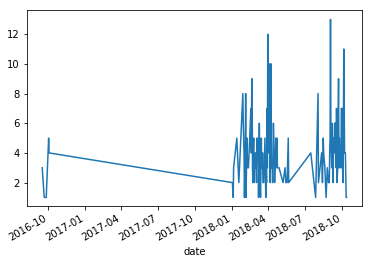

In [22]:
skeevo_df.groupby('date')['date'].count().plot()

In [26]:
df2.to_json('./all_games.json.gz', orient='records', lines=True, compression='gzip')

In [23]:
pa_table = pa.Table.from_pandas(skeevo_df)

NotImplementedError: struct<championId: int64, pickTurn: int64>